# Effective amplitude spectrum calculation

In [36]:
import re

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import numba

%matplotlib inline

## Load time series

In [25]:
def load_at2(fname):
    with open(fname) as fp:
        # Skip 3 header lines
        for _ in range(3):
            next(fp)
        # Find count and timestep.
        # Ex: 'NPTS=   5093, DT=   .0100 SEC, '
        # Here a regular expression is used to find numbers in the line
        parts = re.findall(r'[.0-9]+', next(fp))
        count = int(parts[0])
        time_step = float(parts[1])
        accels = np.array([p for l in fp for p in l.split()]).astype(float)
        
    return {'time_step': time_step, 'accels': accels}

In [26]:
fnames = ['data/RSN763_LOMAP_GIL067.AT2', 'data/RSN763_LOMAP_GIL337.AT2']

time_series = [load_at2(fname) for fname in fnames]

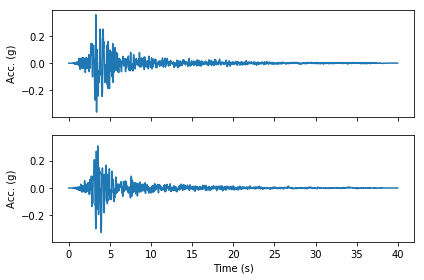

In [27]:
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)

for ax, ts in zip(axes, time_series):
    times = ts['time_step'] * np.arange(ts['accels'].size)
    ax.plot(times, ts['accels'])

plt.setp(axes, ylabel='Acc. (g)')
axes[-1].set(xlabel='Time (s)')

fig.tight_layout()

## Calculate Fourier spectra

In [28]:
assert len(time_series[0]) == len(time_series[1])

In [29]:
for ts in time_series:
    ts['fourier_amps'] = np.fft.rfft(ts['accels'])
    
ts0 = time_series[0]
freqs = np.fft.rfftfreq(ts0['accels'].size, d=ts0['time_step'])

effect_amps = np.sqrt(np.mean(
    [np.abs(ts['fourier_amps']) ** 2 for ts in time_series], axis=0))

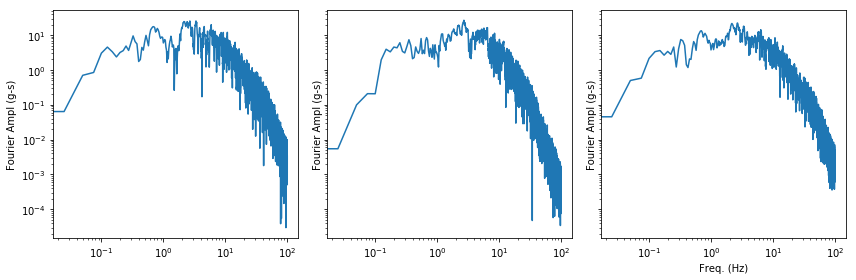

In [30]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))

for ts, ax in zip(time_series, axes):
    ax.plot(freqs, np.abs(ts['fourier_amps']))
    
axes[-1].plot(freqs, np.abs(effect_amps))

plt.setp(axes, ylabel='Fourier Ampl (g-s)', xscale='log', yscale='log')
axes[-1].set(xlabel='Freq. (Hz)')

fig.tight_layout()

## Smoothed spectrum

In [32]:
@numba.jit
def konno_omachi_smooth(freqs, amps, bandwidth, fc):
    # FIXME revisit this
    # Limiting calculation at 3 provides a window value of 4.9E-6 and speeds up
    # calculation
    max_ratio = 10 ** (3 / bandwidth)

    window_total = 0
    total = 0

    for i, freq in enumerate(freqs):
        if abs(freq - fc) < 1E-6:
            window = 1.
        elif (abs(freq - 0) < 1E-6) or (abs(fc - 0) < 1E-6):
            window = 0
        elif (freq / fc) > max_ratio or (fc / freq) > max_ratio:
            continue
        else:
            x = bandwidth * np.log10(freq / fc)
            window = (np.sin(x) / x) ** 4

        total += window * amps[i]
        window_total += window

    return total / window_total

In [34]:
ko_bandwidth = 30
freqs_interp = np.logspace(-1, 2, num=301)
smoothed = np.array([
    konno_omachi_smooth(freqs, effect_amps, ko_bandwidth, fc)
    for fc in freqs_interp
])

/usr/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


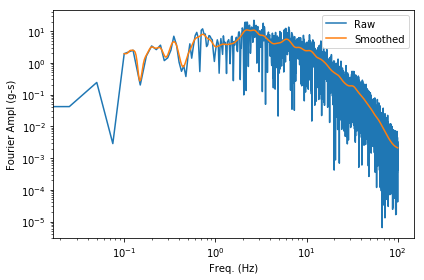

In [35]:
fig, ax = plt.subplots()

ax.plot(freqs, effect_amps, label='Raw')
ax.plot(freqs_interp, smoothed, label='Smoothed')

ax.set(
    xlabel='Freq. (Hz)', xscale='log',
    ylabel='Fourier Ampl (g-s)', yscale='log'
)
ax.legend()

fig.tight_layout()

In [39]:
df = pd.DataFrame.from_records(
    np.c_[freqs_interp, smoothed], 
    columns=['freq', 'effect_amp']
)
df

,freq,effect_amp
0,(0.1+0j),(1.9379650735556668+0.920918396962456j)
1,(0.10232929922807542+0j),(1.9387868482763189+0.9162250355270852j)
2,(0.10471285480508996+0j),(1.945283948576248+0.8791184669954758j)
3,(0.10715193052376065+0j),(1.975090423571319+0.7088862162939863j)
4,(0.1096478196143185+0j),(2.0689111789273835+0.17305236309873315j)
5,(0.11220184543019636+0j),(2.2434210198203948-0.8236170850560413j)
6,(0.1148153621496883+0j),(2.3990200766166097-1.7122823046041111j)
7,(0.11748975549395298+0j),(2.468675061461144-2.1100993844374063j)
8,(0.12022644346174129+0j),(2.4881963932934563-2.222623395012839j)
9,(0.12302687708123815+0j),(2.4880201052139936-2.246600215438626j)
